In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

# import utils
import sys
sys.path.append('../../../utils')
import price_models, rv_estimators

In [31]:
%load_ext autoreload
%autoreload 2

## Heston

In [17]:
mu = 0
sigma = 0.3 # vol of vol
theta = 0.1 # long run variance
rho = -0.3 # correlation
kappa = 1 # mean reversion speed
nu0 = 0.1 # initial variance
S0 = 100
T = 1/365
dt = 1/(365*24*60*60)

heston = price_models.Heston(mu, sigma, theta, rho, kappa, nu0)
S, nu = heston.simulate(T, dt, S0)
# heston.plot(S, nu)
sigma_eps = 1e-3
n = len(S)
c_opt = (T / (12*sigma_eps**4) * np.sum(nu**2)*dt) ** (1/3)
K_opt = int(c_opt*n**(2/3))
K_opt = int(0.01 * n**(2/3)) # easier
print(f"Optimal K: {K_opt}")
print(f"Number of observations: {n}")

iv_real = np.sum(nu.values)*dt


noisy_ts = np.log(S) + np.random.normal(0, sigma_eps, S.shape)
iv_naive_est  = rv_estimators.rv_naive(noisy_ts, pd.Timedelta(100*dt*365, 'D'), verbose=False)
print(f"Naive Rel. Error: {(iv_naive_est-iv_real)/iv_real}")
iv_multigrid_est = rv_estimators.rv_multigrid(noisy_ts, pd.Timedelta(100*dt*365, 'D'), K=K_opt, verbose=False)
print(f"Multigrid Rel. Error: {(iv_multigrid_est-iv_real)/iv_real}")
iv_best_est = rv_estimators.rv_best(noisy_ts, pd.Timedelta(100*dt*365, 'D'), K=K_opt, verbose=False)
print(f"Best Rel. Error: {(iv_best_est-iv_real)/iv_real}")

Optimal K: 19
Number of observations: 86400
Naive Rel. Error: 5.6931266071761435
Multigrid Rel. Error: 0.19996101372895594
Best Rel. Error: -0.14496985308823568


In [64]:
c_opt = ((T / (12*sigma_eps**4)) * np.sum(nu**2)*dt) ** (1/3)
K_opt = int(c_opt*n**(2/3))
print(f"Optimal c: {c_opt}")
print(f"Optimal K: {K_opt}")
print(f"Number of observations: {n}")

Optimal c: 18.00974504615853
Optimal K: 35197
Number of observations: 86400


In [75]:
M = 100
# using parameters from https://www.princeton.edu/~yacine/liquidity.pdf
theta = 0.1
kappa = 5
sigma = 0.5 # other possible values: 0.1, 0.3, 0.5, 0.75, 1; but 0.5 is advised in the paper
sigma_eps = 0.001

assert 2*kappa*theta > sigma**2, "Feller condition not satisfied"

all_nu0 = np.full(M, theta) # initial variance set to long-run variance
all_iv_real = np.zeros(M)
all_iv_naive_est = np.zeros(M)
all_iv_multigrid_est = np.zeros(M)
all_iv_best_est = np.zeros(M)

K = 10

for i in tqdm(range(M)):
    heston = price_models.Heston(mu, sigma, theta, rho, kappa, all_nu0[i])
    S, nu = heston.simulate(T, dt, S0)
    if (nu<0).any():
        print(f"Negative variance in simulation {i}")
    X = np.log(S) # latent log-price process
    microstructure_noise = np.random.normal(loc=0, scale=sigma_eps, size=X.shape)
    Y = X + microstructure_noise
    all_iv_real[i] = np.sum(nu.values)*dt
    all_iv_naive_est[i] = rv_estimators.rv_naive(ts=Y, tau=pd.Timedelta('1s'), verbose=False)
    all_iv_multigrid_est[i] = rv_estimators.rv_multigrid(ts=Y, tau=pd.Timedelta('1s'), K=100, verbose=False)
    all_iv_best_est[i] = rv_estimators.rv_best(ts=Y, tau=pd.Timedelta('1s'), K=100, verbose=False)

 23%|██▎       | 23/100 [00:10<00:35,  2.18it/s]

In [ ]:
# using K=10

# histogram of relative errors
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot((all_iv_naive_est-all_iv_real)/all_iv_real, ax=ax[0], kde=True)
ax[0].set_title("Naive")
sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[1], kde=True)
ax[1].set_title("Multigrid")
sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[2], kde=True)
ax[2].set_title("Best")
plt.show()

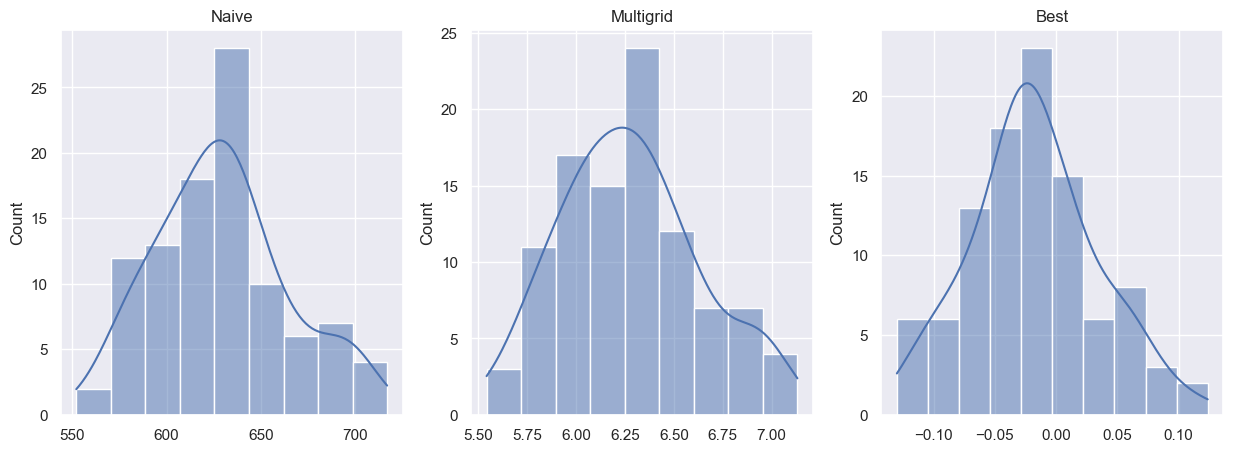

In [72]:
# # using K=100

# # histogram of relative errors
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot((all_iv_naive_est-all_iv_real)/all_iv_real, ax=ax[0], kde=True)
# ax[0].set_title("Naive")
# sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[1], kde=True)
# ax[1].set_title("Multigrid")
# sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[2], kde=True)
# ax[2].set_title("Best")
# plt.show()

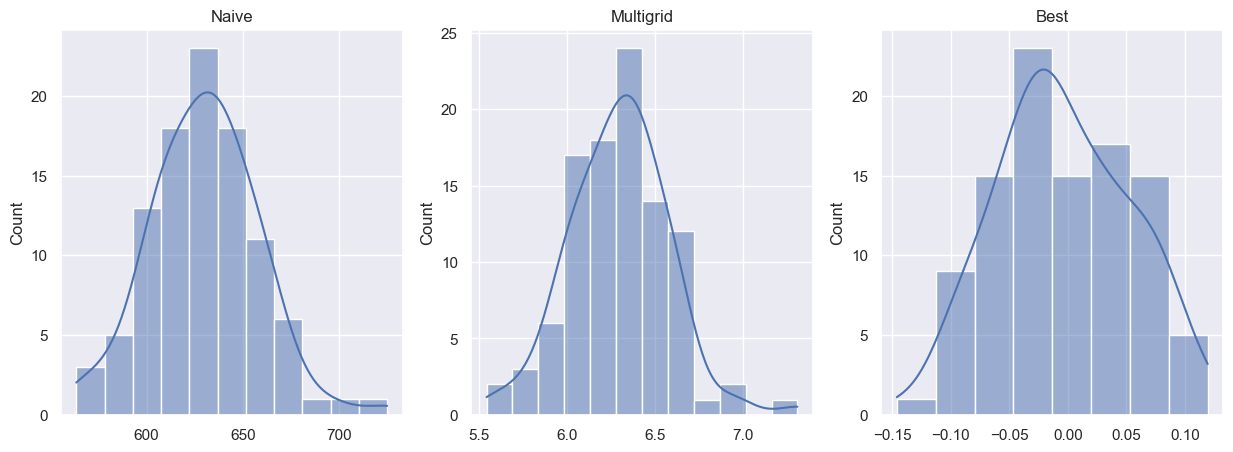

In [70]:
# # using K=1000

# # histogram of relative errors
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot((all_iv_naive_est-all_iv_real)/all_iv_real, ax=ax[0], kde=True)
# ax[0].set_title("Naive")
# sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[1], kde=True)
# ax[1].set_title("Multigrid")
# sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[2], kde=True)
# ax[2].set_title("Best")
# plt.show()

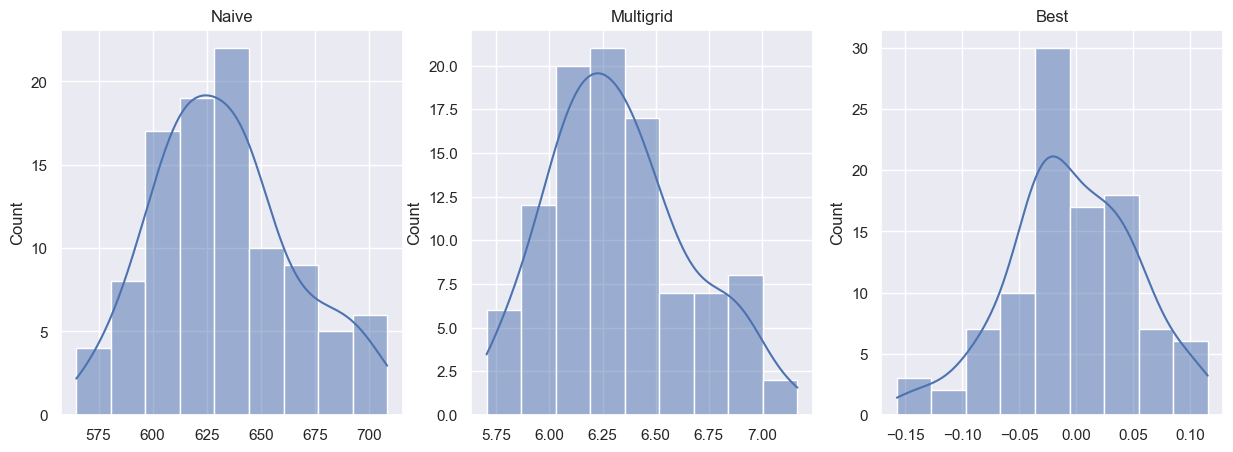

In [68]:
# #using nbar=(n-K+1)/K

# # using K = K_opt = 35000
# # histogram of relative errors
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot((all_iv_naive_est-all_iv_real)/all_iv_real, ax=ax[0], kde=True)
# ax[0].set_title("Naive")
# sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[1], kde=True)
# ax[1].set_title("Multigrid")
# sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[2], kde=True)
# ax[2].set_title("Best")
# plt.show()

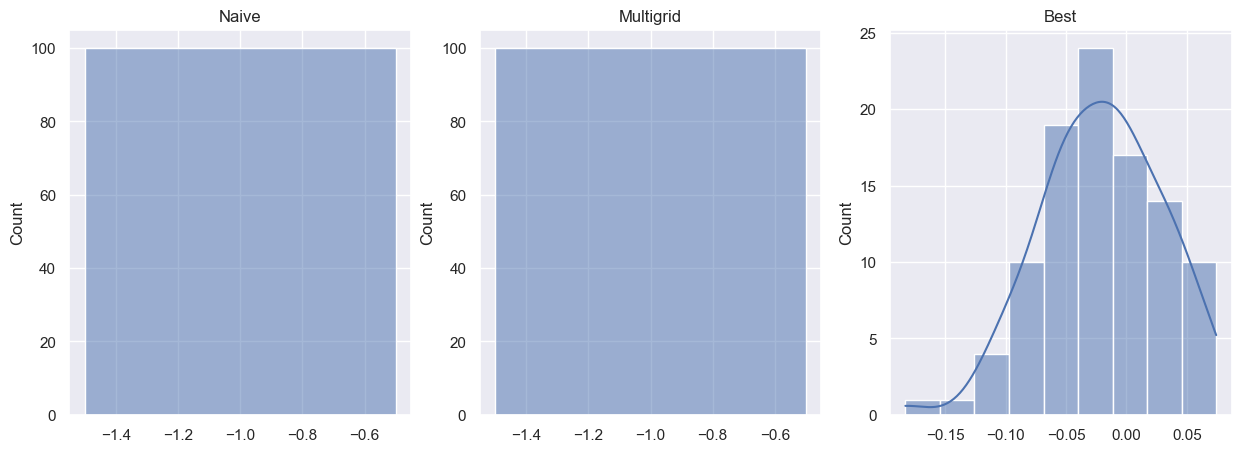

In [56]:
# using nbar=n/K

# # histogram of relative errors
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot((all_iv_naive_est-all_iv_real)/all_iv_real, ax=ax[0], kde=True)
# ax[0].set_title("Naive")
# sns.histplot((all_iv_multigrid_est-all_iv_real)/all_iv_real, ax=ax[1], kde=True)
# ax[1].set_title("Multigrid")
# sns.histplot((all_iv_best_est-all_iv_real)/all_iv_real, ax=ax[2], kde=True)
# ax[2].set_title("Best")
# plt.show()